# Machine Learning and Pattern Recognition (MLPR)

# Assignment 2

# Georgios Pligoropoulos - s1687568

## November 2016 - 1st Semester

In [1]:
import math
import imp
from scipy import io
from sklearn.model_selection import KFold
import numpy as np
from matplotlib import pyplot as plt
import time

#or notebook
%matplotlib inline

In [2]:
import sys
mlprDir = '/home/student/Dropbox/MSc_Artificial_Intelligence/mlpr_Machine_Learning_Pattern_Recognition/mlpr'
sys.path.append(mlprDir)

In [3]:
randomSeed = 0

In [4]:
ctData = io.loadmat('ct_data.mat', squeeze_me=True) #“squeeze_me=True” so thaty_train.shapeis(N,)ratherthan(N,1)
ctDataLen = len(ctData)
ctDataLen

9

In [5]:
ctData.keys()

['X_val',
 'X_train',
 'X_test',
 '__header__',
 '__globals__',
 'y_val',
 'y_train',
 '__version__',
 'y_test']

In [6]:
assert len(ctData['y_train'].shape) == 1, "the squeeze me = True above has failed"

In [7]:
def convertDictionaryToVariables(dictionary):
    """http://stackoverflow.com/questions/18090672/convert-dictionary-entries-into-variables-python"""
    for key,val in dictionary.items():
        exec(key + '=val')

In [8]:
convertDictionaryToVariables(ctData) # TODO: does not work in python notebook ??

In [9]:
Xtrain, Xval, Xtest, yTrain, yVal, yTest = ctData['X_train'], ctData['X_val'], ctData['X_test'], \
    ctData['y_train'], ctData['y_val'], ctData['y_test']

In [10]:
ctData['__header__']

'MATLAB 5.0 MAT-file, written by Octave 4.0.0, 2016-10-30 15:41:35 UTC'

In [11]:
ctData['__globals__']

[]

In [12]:
ctData['__version__']

'1.0'

In [13]:
Xtrain.shape, yTrain.shape

((40754, 384), (40754,))

In [14]:
Xval.shape, yVal.shape

((5785, 384), (5785,))

In [15]:
Xtest.shape, yTest.shape

((6961, 384), (6961,))

In [16]:
someWhereInTheMiddleOfTraining = range(len(Xtrain)/2,len(Xtrain)/2 + 6)

In [17]:
Xtrain[someWhereInTheMiddleOfTraining]

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      , -0.25    ],
       [ 0.      ,  0.      ,  0.      , ...,  0.963103,  0.      , -0.25    ],
       [ 0.      ,  0.      ,  0.      , ...,  0.975469,  0.      , -0.25    ],
       [ 0.      ,  0.      ,  0.      , ...,  0.807768,  0.      , -0.25    ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      , -0.25    ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      , -0.25    ]])

In [18]:
yTrain[someWhereInTheMiddleOfTraining]

array([-0.39463686,  0.37122723,  0.37342168,  0.36903278,  0.33611602,
        0.35147717])

### 1a

Verifying that the mean of the training positions in yTrain is zero

In [19]:
np.allclose(np.mean(yTrain), 0)

True

The mean of the 5,785 positions in they_valarray is not zero.

In [20]:
yValMean = np.mean(yVal)
yValMean

-0.21600850932415991

If we gathered a second dataset and computed its mean in the same way, we would get a different mean. For some datasets the mean will be bigger than the underlying true mean, sometimes it will be smaller.  
Here we do not have a second dataset and thus we are stuck with that. But we can use the standard deviation to see how much the mean would vary.

In [21]:
def getMeanError(arr):
    return np.std(arr)/math.sqrt(len(arr))

In [22]:
validationMeanError = getMeanError(yVal)
print "The standard error of the validation mean is %f +/- %f" % (yValMean, validationMeanError)

The standard error of the validation mean is -0.216009 +/- 0.012903


In [23]:
firstPartOfTraining = yTrain[:len(yVal)]

In [24]:
firstPartOfTrainingMeanError = getMeanError(firstPartOfTraining)
print "The standard error of the first part of training mean is %f +/- %f" %\
    (np.mean(firstPartOfTraining), firstPartOfTrainingMeanError)

The standard error of the first part of training mean is -0.442477 +/- 0.011926


Why these standard error bars do not reliably indicate what the average of locations in future CT slice data will be?

Well intuitively the CT scan is a complex process and it involves the complexity of the human body. Here we have less than 60.000 instances in total which is a very small number in comparison with the population. Given that the person is totally still. Because if the person is slightly moving when the CT scan is being operating this will add noise to the data giving slight variations to the inputs thus changing the mean.
We need many more datasets to derive a better mean and have a better approximation of the standard error.  
In addition we have taken into account the **assumption that the observations are independent** from each other which might not be the case.

### 1b

In [25]:
def checkIfArrayContainsIdenticalElements(arr):
    assert len(arr) >= 1, "do not call this function if array is empty"
    #reduce(lambda x,y : x if x == y else False, arr) == arr[0]
    return np.all(np.array(arr) == arr[0])

In [26]:
def identifyRedundantAttributes(dataset):
    """returns a binary mask suggesting the columns where all the instances have the same value
    thus contributing zero information"""
    return np.apply_along_axis(checkIfArrayContainsIdenticalElements, axis=0, arr = dataset)

In [27]:
redundantAttrs = identifyRedundantAttributes(Xtrain)
redundantAttrs.shape

(384,)

In [28]:
Xtrain.shape

(40754, 384)

In [29]:
def removeRedundantAttrs(dataset, redundantAttributes):
    fixedDataset = np.delete(dataset, np.argwhere(redundantAttributes), axis=1)
    assert len(redundantAttributes[redundantAttributes==True]) == dataset.shape[1] - fixedDataset.shape[1],\
        "%d vs %d" % (len(redundantAttributes[redundantAttributes==True]), dataset.shape[1] - fixedDataset.shape[1])
    return fixedDataset

In [30]:
Xtr = removeRedundantAttrs(Xtrain, redundantAttrs)
Xtr.shape

(40754, 379)

In [31]:
Xvalid = removeRedundantAttrs(Xval, redundantAttrs)
Xvalid.shape

(5785, 379)

In [32]:
Xtesting = removeRedundantAttrs(Xtest, redundantAttrs)
Xtesting.shape

(6961, 379)

We have removed the following columns:

In [33]:
np.argwhere(redundantAttrs)

array([[ 59],
       [ 69],
       [179],
       [189],
       [351]])

## 2

In [34]:
alpha = 10

In [35]:
# We use that only for verification
def closedFormSolutionForRidgeRegression(X, y, l2):
    """eye (I) matrix is modified to not penalize intercept"""
    lenX = len(X)
    H = np.hstack( (np.ones(lenX)[np.newaxis].T, X) )
    eye = np.eye(H.shape[1])
    eyeModified = eye
    eyeModified[0,0] = 0
    
    #return np.linalg.inv(H.T.dot(H) + l2 * eyeModified).dot(H.T).dot(y)
    #these two are equivalent but the 
    return np.linalg.solve(H.T.dot(H) + l2 * eyeModified, H.T.dot(y))

In [36]:
myWeights = closedFormSolutionForRidgeRegression(Xtr, yTrain, alpha)
myWeights.shape

(380,)

In [37]:
def augmentTrainingDataWithOnesForBias(X):
    return np.hstack( (np.ones(len(X))[np.newaxis].T, X) )

In [38]:
H = augmentTrainingDataWithOnesForBias(Xtr)
H.shape

(40754, 380)

In [39]:
def addRowsForPseudoDataTrick(X, y, l2):
    """http://statweb.stanford.edu/~tibs/sta305files/Rudyregularization.pdf"""
    size = X.shape[1]
    eye = np.eye(size)
    eyeModified = eye
    eyeModified[0,0] = 0
    omega = math.sqrt(l2) * eyeModified
    return np.concatenate( (X, omega), axis=0), np.concatenate((y, np.zeros(size)))

In [40]:
def fit_linreg(X, yy, alpha):
    inputs, outputs = addRowsForPseudoDataTrick(augmentTrainingDataWithOnesForBias(X), yy, alpha)
    return np.linalg.lstsq(inputs, outputs)[0]

In [41]:
weights = fit_linreg(Xtr, yTrain, alpha)

In [42]:
assert np.allclose(myWeights, weights), "means that the two solutions are not identical"

In [43]:
from ct_support_code import fit_linreg_gradopt

In [44]:
gradoptFittedWeights, gradoptFittedBias = fit_linreg_gradopt(Xtr, yTrain, alpha)

In [45]:
gradoptFittedWeights.shape, gradoptFittedBias.shape

((379,), ())

In [46]:
gradoptFittedWeightsAndBias = np.concatenate( ( np.array([gradoptFittedBias]), gradoptFittedWeights) )
gradoptFittedWeightsAndBias.shape

(380,)

In [47]:
np.allclose(gradoptFittedWeightsAndBias, weights)

False

In [48]:
print "let's print the bias and some weights to see where is the difference, or how big it is"
np.hstack( (gradoptFittedWeightsAndBias[np.newaxis].T, weights[np.newaxis].T) )[:20]

let's print the bias and some weights to see where is the difference, or how big it is


array([[ 0.13824328,  0.13941109],
       [-0.05513268, -0.05512783],
       [-0.10870641, -0.1087216 ],
       [ 0.07951081,  0.07947379],
       [ 0.28194341,  0.28193662],
       [ 0.26014425,  0.26013513],
       [ 0.11940019,  0.11934693],
       [ 0.0142664 ,  0.0142611 ],
       [ 0.23497929,  0.23496813],
       [-0.32012978, -0.32012748],
       [-0.04879251, -0.04877961],
       [-0.04658537, -0.04658515],
       [ 0.05159682,  0.05160122],
       [-0.02323546, -0.02319087],
       [-0.00205468, -0.00202425],
       [-0.0096499 , -0.00962028],
       [ 0.03985583,  0.03987988],
       [ 0.02542174,  0.02538214],
       [ 0.01492785,  0.01503999],
       [-0.10848049, -0.10850978]])

In [49]:
np.allclose(gradoptFittedWeightsAndBias, weights, atol=1e-2)

True

We see from the above two cells that the weights including the bias are very close, actually not so close to be considered identical but when we loosened the tolerance we found out that they are very close together as we can observe by eye looking at the values side by side.

This happens because as the algorithm tries to converge 1) maybe the learning rate is not the identical and 2) the threshold for convergence might not be so strict meaning that the provided solutions from the *fit_linreg_gradopt* are good enough for minimizing the error and thus the iterations stop without reaching the true global minimum point.

In addiction taking a look at the implemented code we see that the optimizer is set to iterate at maximum 500 times. This could also be a limitting factor to reach to the absolutely optimal solution.

Note that for the current problem and current dataset the closed form solution is much faster than the gradient descent approach

In [50]:
from ct_support_code import linreg_cost

In [51]:
def getParams(w):
    return w[1:], w[0]

In [52]:
trainingCostForClosedForm = linreg_cost(getParams(weights), Xtr, yTrain, alpha)
trainingCostForClosedForm[0]

5217.9279636734

In [53]:
validationCostForClosedForm = linreg_cost(getParams(weights), Xvalid, yVal, alpha)
validationCostForClosedForm[0]

1083.2545883098387

The above are the RSS scores, we do not want that because they are not immune to scaling. We want the RMSE

In [54]:
from sklearn.metrics import mean_squared_error

In [55]:
def getPredictions(X, w, biases):
    return X.dot(w) + biases

In [56]:
def getRMSE(trueTargets, predictions):
    mse = np.sum((trueTargets - predictions)**2)/len(trueTargets)
    #mse1 = mean_squared_error(trueTargets, predictions)
    #assert mse == mse1 
    return math.sqrt(mse)

In [57]:
trainingRMSEforClosedForm = getRMSE(trueTargets=yTrain, predictions=getPredictions(Xtr, weights[1:], weights[0]))
trainingRMSEforClosedForm

0.35566175191574384

In [58]:
validationRMSEforClosedForm = getRMSE(trueTargets=yVal, predictions=getPredictions(Xvalid, weights[1:], weights[0]))
validationRMSEforClosedForm

0.42000850675140733

Now we can compare the two errors directly and see that the error for training is indeed smaller that the error for the unseen validation data even though the regularization was used

In [59]:
w_s = gradoptFittedWeights
b_s = gradoptFittedBias
trainingRMSEforGradientDescent = getRMSE(trueTargets=yTrain, predictions=getPredictions(Xtr,  w_s, b_s))
validationRMSEforGradientDescent = getRMSE(trueTargets=yVal, predictions=getPredictions(Xvalid, w_s, b_s))

trainingRMSEforGradientDescent, validationRMSEforGradientDescent

(0.35566091528208404, 0.42000265085266136)

In [60]:
np.allclose(np.array([trainingRMSEforClosedForm, validationRMSEforClosedForm]),
           np.array([trainingRMSEforGradientDescent, validationRMSEforGradientDescent]), atol=1e-5)

True

The solution for the gradient descent is almost identical with a tolerance of 1e-5 tot the closed form solution as expected.

In general we are expecting the closed-form solution to always be the truly optimal solution for linear regression.

The closed form solution is not used in practice in many cases because the computation might be very slow in comparison to gradient descent. The more the dimensionality increasing the larger is this issue

## 3a

In [61]:
Xmu = np.mean(Xtr, axis=0)
Xmu.shape

(379,)

In [62]:
XtrainNorm = Xtr - Xmu
XtrainNorm.shape

(40754, 379)

In [63]:
assert np.all(XtrainNorm[0] == Xtr[0] - Xmu),\
    "just an almost silly assertion to verify that the broadcasting of numpy is working as expected"

In [64]:
XvalNorm = Xvalid - Xmu
XvalNorm.shape

(5785, 379)

Let's first exploit sklearn to easily create a scree plot of the PCA to see really how much is the role of each Principal Component

In [65]:
import sklearn.decomposition as deco

In [66]:
pca = deco.PCA(n_components=XtrainNorm.shape[1])
pca

PCA(copy=True, iterated_power='auto', n_components=379, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [67]:
pca.fit(XtrainNorm)

PCA(copy=True, iterated_power='auto', n_components=379, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

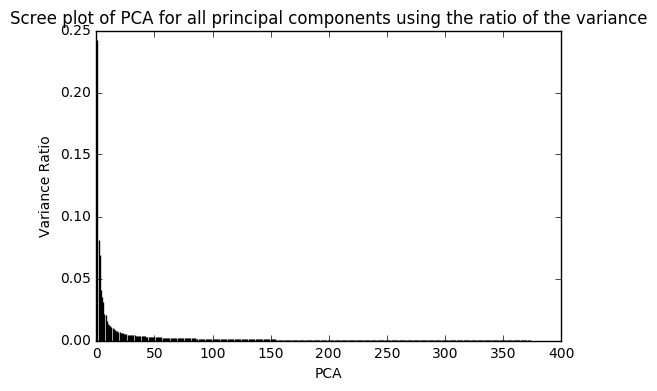

In [68]:
fig = plt.figure()
xsize =XtrainNorm.shape[1]
plt.bar( range(1,xsize+1), pca.explained_variance_ratio_, width = 1/(xsize/2) )
plt.title('Scree plot of PCA for all principal components using the ratio of the variance')
plt.xlabel('PCA')
plt.ylabel('Variance Ratio')
plt.show()

From this first plot it seems that after the 150th Principal Component there is little information. The variance is much less significant in comparison to the first Principal Components. Let's replot

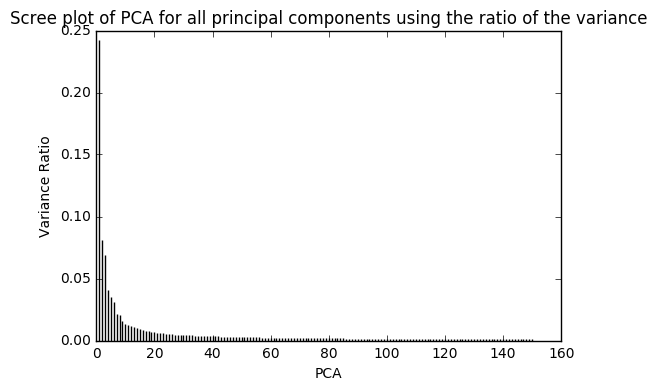

In [69]:
fig = plt.figure()
xsize = 150
plt.bar( range(1,xsize+1), pca.explained_variance_ratio_[:xsize], width = 1/(xsize/2) )
plt.title('Scree plot of PCA for all principal components using the ratio of the variance')
plt.xlabel('PCA')
plt.ylabel('Variance Ratio')
plt.show()

In [70]:
from ct_support_code import pca_zm_proj

In [71]:
V = pca_zm_proj(XtrainNorm)
V.shape

(379, 379)

In [72]:
K=10

In [73]:
V = pca_zm_proj(XtrainNorm, K=K).real # we get back complex numbers, not sure why
V.shape

(379, 10)

In [74]:
Xtrain10 = XtrainNorm.dot(V)

In [75]:
Xtrain10.shape

(40754, 10)

In [76]:
Xvalid10 = XvalNorm.dot(V)
Xvalid10.shape

(5785, 10)

In [77]:
weights = fit_linreg(Xtrain10, yTrain, alpha)
weights.shape

(11,)

In [78]:
print "Training Root Mean Square Error with PCA dimensionality reduction to K=%d" % K
trainingRMSEpca10 = getRMSE(trueTargets=yTrain, predictions=getPredictions(Xtrain10, weights[1:], weights[0]))
trainingRMSEpca10

Training Root Mean Square Error with PCA dimensionality reduction to K=10


0.5724151784607797

In [79]:
print "Validation Root Mean Square Error with PCA dimensionality reduction to K=%d" % K
validationRMSEpca10 = getRMSE(trueTargets=yVal, predictions=getPredictions(Xvalid10, weights[1:], weights[0]))
validationRMSEpca10

Validation Root Mean Square Error with PCA dimensionality reduction to K=10


0.5712708979178774

Both errors are smaller than when using all of the features. Meaning that now we are doing worse in terms of regression but effectively we have a faster system since the matrix multiplication are reduced a lot. So there is a tradeoff here.

We are noticing that the training error has increased in relation to the validation error.  
This is happening because unlike before that the model was fitted to the peculiarities of the training data we now have new features, actually we have the best possible linear combinations of our features and we are not using all of them, but only few of them.
Therefore it is more unlikely that we are going to overfit to our training data.

In [80]:
K=100

In [81]:
V = pca_zm_proj(XtrainNorm, K=K).real # we get back complex numbers, not sure why
V.shape

(379, 100)

In [82]:
Xtrain100 = XtrainNorm.dot(V)

In [83]:
Xtrain100.shape

(40754, 100)

In [84]:
Xvalid100 = XvalNorm.dot(V)
Xvalid100.shape

(5785, 100)

In [85]:
weights = fit_linreg(Xtrain100, yTrain, alpha)
weights.shape

(101,)

In [86]:
print "Training Root Mean Square Error with PCA dimensionality reduction to K=%d" % K
trainingRMSEpca100 = getRMSE(trueTargets=yTrain, predictions=getPredictions(Xtrain100, weights[1:], weights[0]))
trainingRMSEpca100

Training Root Mean Square Error with PCA dimensionality reduction to K=100


0.4105637933749981

In [87]:
print "Validation Root Mean Square Error with PCA dimensionality reduction to K=%d" % K
validationRMSEpca100 = getRMSE(trueTargets=yVal, predictions=getPredictions(Xvalid100, weights[1:], weights[0]))
validationRMSEpca100

Validation Root Mean Square Error with PCA dimensionality reduction to K=100


0.4326955524607758

By increasing the number of principal components we are including more information in the model and we see that we have approached the RMSE of the original experiment but with much fewer attributes, only 100 in comparison to 379. Again our computations are going to be faster.

The RMSE of K=100 is smaller, better, than the RMSE for K=10 which is expected because we have included more information in the model. But as we are adding information we see that the training error is deviating from the validation error because these peculiarities of the training data start to re-appear. The gap is still much closer though.

## 3b

(array([  52.,    0.,    0.,    0.,  289.,    2.,    3.,    0.,    0.,
           1.,    2.,    2.,    3.,    1.,    3.,    3.,    3.,    3.,
           3.,    9.]),
 array([ -2.50000000e-01,  -1.87548600e-01,  -1.25097200e-01,
         -6.26458000e-02,  -1.94400000e-04,   6.22570000e-02,
          1.24708400e-01,   1.87159800e-01,   2.49611200e-01,
          3.12062600e-01,   3.74514000e-01,   4.36965400e-01,
          4.99416800e-01,   5.61868200e-01,   6.24319600e-01,
          6.86771000e-01,   7.49222400e-01,   8.11673800e-01,
          8.74125200e-01,   9.36576600e-01,   9.99028000e-01]),
 <a list of 20 Patch objects>)

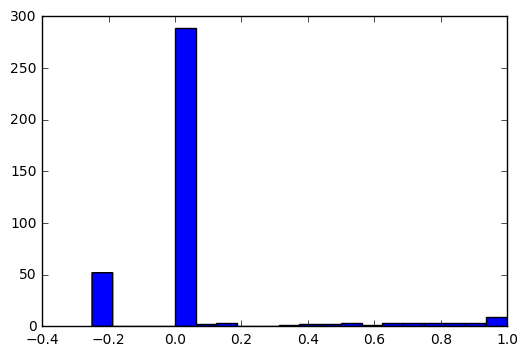

In [88]:
#Plot a histogram of the values of the 46th feature (index 45 in python).
index = 45
plt.hist(Xtr[index],bins=20)

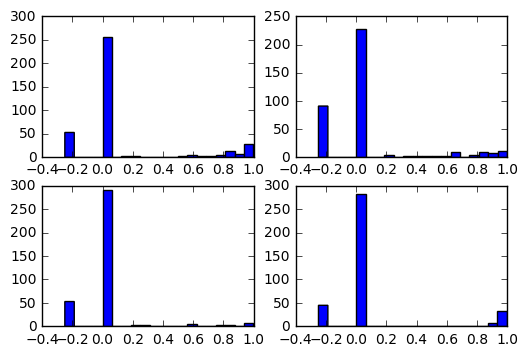

In [89]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flat
ax0.hist(Xtr[0],bins=20)
ax1.hist(Xtr[-1],bins=20)
ax2.hist(Xtr[100],bins=20)
ax3.hist(Xtr[200],bins=20)
print

By plotting these randomly selected plots and the plot with index 45, above, we notice that lots of features are near to zero and -0.25

In [90]:
totalElements = Xtr.shape[0] * Xtr.shape[1]

In [91]:
target = -0.25

In [92]:
count = len(Xtr[Xtr==target])
count

2297040

In [93]:
print "The fraction of the values in training matrix that are equal to %f is %f" %\
    (target, float(count) / float(totalElements))

The fraction of the values in training matrix that are equal to -0.250000 is 0.148716


In [94]:
target = 0

In [95]:
count = len(Xtr[Xtr==target])
count

10163563

In [96]:
print "The fraction of the values in training matrix that are equal to %d is %f" %\
    (target, float(count) / float(totalElements))

The fraction of the values in training matrix that are equal to 0 is 0.658016


In [97]:
aug_fn = lambda X : np.hstack([X, X==0, X<0])

In [98]:
Xtr_augmented = aug_fn(Xtr)

In [99]:
Xtr_augmented.shape

(40754, 1137)

In [100]:
weights = fit_linreg(Xtr_augmented, yTrain, alpha)
weights.shape

(1138,)

In [101]:
trainingRMSEbinaryAugmentation = getRMSE(trueTargets=yTrain, predictions=getPredictions(Xtr_augmented, weights[1:], weights[0]))
trainingRMSEbinaryAugmentation

0.3178319185485654

In [102]:
Xvalid_binary_aug = aug_fn(Xvalid)
Xvalid_binary_aug.shape

(5785, 1137)

In [103]:
testingRMSEbinaryAugmentation = getRMSE(trueTargets=yVal, predictions=getPredictions(Xvalid_binary_aug, weights[1:], weights[0]))
testingRMSEbinaryAugmentation

0.3770058378403649

We notice that after applying the binary augmentation (which tripled the number of our attributes though) we managed to achieve a lower RMSE for both the training and validation error

The error goes down, thus the model improves, because all of those zeros present in the input array when multiplied by the weights they "kill" the weights and the model becomes inflexible.

One more reason is that the negative values seem like a special category which is treated like a number. By making it binary we treat it as we would treat binary categories in linear regression.

Another reason might be because we are doing linear regression and there is not really a linear relationship between our data and our outputs/targets variables

## 4. Inverted Classification Tasks

In [104]:
from ct_support_code import minimize_list, logreg_cost

In [105]:
K = 10 # number of thresholded classification problems to fit

In [106]:
mx = np.max(yTrain)
mx

2.2265180851800834

In [107]:
mn = np.min(yTrain)
mn

-1.8679386519531087

In [108]:
hh = (mx-mn)/(K+1)
hh

0.3722233397393811

In [109]:
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
thresholds

array([-1.49571531, -1.12349197, -0.75126863, -0.37904529, -0.00682195,
        0.36540139,  0.73762473,  1.10984807,  1.48207141,  1.85429475])

In [110]:
def fitLogisticRegression(X, yy, alpha):
    D = X.shape[1]
    args = (X, yy, alpha)
    init  = (np.zeros(D), np.array(0)) #initialize weights and biases to zero and start from there
    #init  = (np.zeros(D), 0) #actually same thing
    ww, bb = minimize_list(logreg_cost, init, args)
    return ww, bb

In [111]:
paramsCollection = []

In [112]:
for kk in range(K):
    labels = yTrain > thresholds[kk]
    #labels (boolean) and labels*1 (which is ones and zeros) has the same behavior in python
    params = fitLogisticRegression(Xtr, labels, alpha)
    paramsCollection.append(params)

In [113]:
def logisticRegression(X, w, b):
    X = np.hstack((np.ones((len(X), 1)),X))
    w = np.concatenate((np.array([b]), w))
    return 1 / (1 + np.exp(- X.dot(w)))

In [114]:
#just initialising with -1 to make sure that if we see a zero or an one it comes from the logistic regression and
#not because of our initialization
probsTrain = -np.ones((len(Xtr),K))

In [115]:
for i, params in enumerate(paramsCollection):
    probsTrain[:, i] = logisticRegression(X= Xtr, w=params[0], b=params[1])

In [116]:
probsTrain.shape

(40754, 10)

In [117]:
probsTrain[:5, :]

array([[  9.96793793e-01,   7.71478616e-02,   8.35548478e-04,
          3.34252213e-04,   8.82304343e-04,   3.81492646e-04,
          1.47085018e-04,   2.59552076e-05,   1.00197970e-06,
          2.85093492e-06],
       [  9.97196504e-01,   3.65736517e-02,   5.55120134e-04,
          6.93762470e-04,   3.12478303e-03,   4.50276758e-04,
          2.91632804e-04,   3.34887243e-05,   2.77678011e-06,
          4.55765983e-06],
       [  9.97595483e-01,   3.78427978e-02,   5.41703673e-04,
          9.14565893e-04,   3.81475234e-03,   4.28759522e-04,
          2.26465379e-04,   2.69257117e-05,   3.73049278e-06,
          4.58520602e-06],
       [  9.97866754e-01,   5.84546716e-02,   3.66980495e-04,
          5.90636557e-04,   8.42530012e-04,   1.88923319e-04,
          9.91816112e-05,   1.91489189e-05,   8.32376037e-06,
          3.82256053e-06],
       [  9.97709884e-01,   5.49115080e-02,   3.59104887e-04,
          4.97237521e-04,   9.58534312e-04,   1.97973117e-04,
          8.85213826e-05

Now let's fit a regularized linear regression model (alpha = 10) to our transformed 10-dimensional training set

In [118]:
alpha = 10
alpha

10

In [119]:
weights = fit_linreg(probsTrain, yTrain, alpha)
weights.shape

(11,)

In [120]:
ww_5 = weights[1:].copy() #just storing the weights for question 5
bb_5 = weights[0].copy()

In [121]:
trainingRMSE = getRMSE(trueTargets=yTrain, predictions=getPredictions(probsTrain, weights[1:], weights[0]))
print "Training RMSE for our reduced by the classification via logistic regression we used above is"
trainingRMSE

Training RMSE for our reduced by the classification via logistic regression we used above is


0.13799833707562892

In [122]:
#just initialising with -1 to make sure that if we see a zero or an one it comes from the logistic regression and
#not because of our initialization
probsVal = -np.ones((len(Xvalid),K))
for i, params in enumerate(paramsCollection):
    probsVal[:, i] = logisticRegression(X=Xvalid, w=params[0], b=params[1])

In [123]:
testingRMSE = getRMSE(trueTargets=yVal, predictions=getPredictions(probsVal, weights[1:], weights[0]))
print "Testing RMSE for our reduced by the classification via logistic regression we used above is"
testingRMSE

Testing RMSE for our reduced by the classification via logistic regression we used above is


0.25151779052868917

We see here that we have improved the model a lot by doing this simple 10 different classifications of the data. The RMSE of both training and validation sets have been improved. We tried to reduce the dimensionality with PCA. However the PCA can only do a (or I must say the best) linear combination of out features. It does that to give a projection of the data on the hyperplane which is parallel to where the variance of the data is maximum. But still we must consider that the best thing that it can do is do a linear combination of the features.  
By doing logistic regression we have imposed some non-linearities which obviously were appropriate for the current data and the RMSE is lower than before.

## 5. Small Neural Network

In [124]:
seed = 16011984

In [125]:
rng = np.random.RandomState(seed=0)

In [126]:
from ct_support_code import nn_cost, minimize_list

We understand here that we have not done full back propagation and therefore we have fitted the two layers of this model separately.

So here we are building a model with two layers or to be more explicit we build a model with a single layer neural network plus a linear regression layer

![alt text](https://s20.postimg.org/ixvissoel/20161106_154202.jpg "Single Layer Neural Network + Linear Regression")

In [127]:
def getRandomParams(D, K, factor = 1e-1):
    """D dimensionality of inputs, K dimensionality of outputs"""
    ww = rng.randn(K) * factor
    bb = rng.randn(1) * factor
    V =  rng.randn(K, D) * factor
    bk = rng.randn(K)
    
    return (ww, bb, V, bk)

In [128]:
initialParams = getRandomParams(D=Xtr.shape[1], K=10)
for initialParam in initialParams:
    print initialParam.shape

(10,)
(1,)
(10, 379)
(10,)


In [129]:
fittedParams = minimize_list(nn_cost, initialParams, (Xtr, yTrain, alpha))

In [130]:
for fittedParam in fittedParams:
    print fittedParam.shape

(10,)
(1,)
(10, 379)
(10,)


In [131]:
rmse = getRMSE(trueTargets=yTrain,predictions=nn_cost(fittedParams, Xtr))
print "printing Root Mean Square Error for some random initial weights"
rmse

printing Root Mean Square Error for some random initial weights


0.09688088075040721

### 5a
Let's try and initialize the model a few times with random parameters that derive from the standard normal distribution multiplied with different factors

In [132]:
factors = np.logspace(-2, 2, 5)
factors

array([  1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
         1.00000000e+01,   1.00000000e+02])

In [133]:
def fitAndScore(factor, K=10):
    fittedParams = minimize_list(nn_cost, getRandomParams(D=Xtr.shape[1],K=K,factor=factor), (Xtr,yTrain,alpha))
    return (
        getRMSE(trueTargets=yTrain,predictions=nn_cost(fittedParams, Xtr)),
        getRMSE(trueTargets=yVal,predictions=nn_cost(fittedParams, Xvalid))
    )


In [134]:
scores = []

for factor in factors:
    scores.append(
        fitAndScore(factor)
    )

ct_support_code.py:201: RuntimeWarning: overflow encountered in exp
  P = 1 / (1 + np.exp(-A)) # N,K


In [135]:
trainErrors = [s[0] for s in scores]
testingErrors = [s[1] for s in scores]

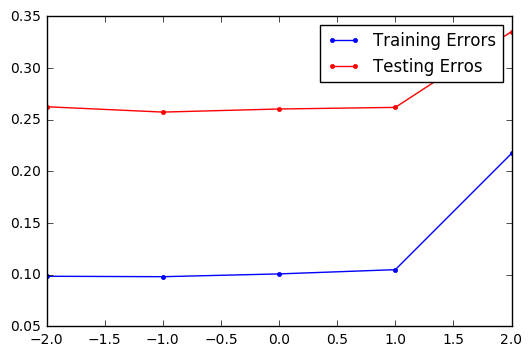

In [136]:
fig = plt.figure()
plt.hold(True)
plt.plot(np.log10(factors), trainErrors, 'b.-')
plt.plot(np.log10(factors),testingErrors, 'r.-')
plt.hold(False)
plt.legend(['Training Errors', 'Testing Erros'])
plt.show()

From the plot above we see that the randomly initially weights give a non-high-variance RMSE ~0.1 for training and ~0.25 for validation but when the weights are very high the sigmoids of the neural network saturate and we get a very bad RMSE

Let's take the mean, max and min RMSE of both training and validation set for the above experiment excluding the value when the saturation occured

In [137]:
trainErrorsFixed = trainErrors[:-1]

In [138]:
minTrainRMSE, maxTrainRMSE, meanTrainRMSE = min(trainErrorsFixed), max(trainErrorsFixed), np.mean(trainErrorsFixed)
minTrainRMSE, maxTrainRMSE, meanTrainRMSE

(0.09814633866350778, 0.10493963986713477, 0.10062341631076448)

In [139]:
testingErrorsFixed = testingErrors[:-1]

In [140]:
minTestRMSE, maxTestRMSE, meanTestRMSE = min(testingErrorsFixed), max(testingErrorsFixed), np.mean(testingErrorsFixed)
minTestRMSE, maxTestRMSE, meanTestRMSE

(0.25743953943756787, 0.26262016764929347, 0.26061968002985814)

### 5b
Let's try and use the weights from the question 4 as the initial parameters and see if this training layer by layer is useful for initialization

In [141]:
paramsCollection

[(array([ -1.80437302e-01,   1.67533871e-01,   8.61282020e-02,
          -5.83533734e-02,  -2.72541556e-01,   1.04598273e-02,
           9.16977667e-02,   1.47728773e-01,   1.13017900e-01,
           1.29221112e-02,  -2.78694450e-01,   5.78223086e-02,
          -3.08833518e-03,  -1.36147721e-01,  -2.20233374e-01,
           4.92464200e-02,   6.59020660e-02,   4.70521424e-02,
           1.82832566e-01,   9.42849169e-02,  -3.76500195e-02,
          -4.01557677e-02,  -3.42812971e-01,  -2.09193694e-01,
          -3.32221638e-01,  -8.31383809e-02,  -2.63569683e-02,
           2.01040638e-03,  -3.23568999e-02,   3.43625389e-02,
           1.10818328e-01,   3.85655344e-01,  -1.98375452e-01,
          -3.92087274e-01,  -1.31271931e-02,  -6.02863279e-01,
          -8.24565257e-01,  -2.54352898e-02,  -6.50608116e-02,
          -1.25150687e-01,   4.18667771e-02,   7.02351165e-02,
          -1.15580001e-01,   1.68518812e-01,   3.70348137e-01,
           1.95061841e-01,  -7.83063331e-01,  -2.839222

In [142]:
len(paramsCollection) #TODO refactor params collection to make it into a matrix to have it ready for question 5

10

In [143]:
bk = np.array([p[1] for p in paramsCollection]) #get biases from params collection

In [144]:
D = Xtr.shape[1]

In [145]:
V = np.zeros((K, D))
V.shape

(10, 379)

In [146]:
weightsFromParamsCollection = [p[0] for p in paramsCollection]

In [147]:
for i, w in enumerate(weightsFromParamsCollection):
    V[i, :] = w

In [148]:
V[:5,:10]

array([[-0.1804373 ,  0.16753387,  0.0861282 , -0.05835337, -0.27254156,
         0.01045983,  0.09169777,  0.14772877,  0.1130179 ,  0.01292211],
       [ 0.23818631, -0.0037519 ,  0.08939135, -0.28249096,  0.46947222,
         0.2428821 , -0.20053769,  0.5639093 ,  0.19279334,  0.02279842],
       [-0.34090875, -0.01084626,  0.15612231,  0.53620278,  1.43310226,
         0.39290399, -0.01777887,  0.16203922, -0.77345654, -0.17547967],
       [-0.47333174, -0.64860932, -0.14091801,  1.33454083,  1.45991401,
         0.16763888,  0.25495831,  0.81614697, -0.70309945, -0.27338187],
       [-0.41188558, -0.61319485, -0.0988138 ,  1.30113018,  1.34673323,
         0.33154783, -0.46113265,  0.59379654, -0.94065742, -0.32934864]])

In [149]:
def getInitialNeuralNetworkState():
    return (ww_5.copy(), bb_5.copy(), V.copy(), bk.copy())

In [150]:
fittedParams = minimize_list(nn_cost, getInitialNeuralNetworkState(), (Xtr, yTrain, alpha))
train_question4_RMSE = getRMSE(trueTargets=yTrain, predictions=nn_cost(fittedParams, Xtr)),
testing_question4_RMSE = getRMSE(trueTargets=yVal, predictions=nn_cost(fittedParams, Xvalid))

In [151]:
train_question4_RMSE

(0.10026697346626232,)

In [152]:
testing_question4_RMSE

0.2613245639516538

We followed a procedure for pretraining / initialization which is called Layer-by-Layer cross-entropy training. In our case it does not seem to yield any amazing results even though the training error is below the mean of the previous experiment and the testing error is slighly above the mean of the previous experiment.

We can only conclude that this methodology is not bad and is guaranteed some good results but not optimal.  
We see that initialization with some random values we were able to find a better local (if not global) minima.

## 6. What's Next?
Here we are going to implement a larger neural network with ten times more neurons. Let's see if we have an improved performance with 100 neurons

In [153]:
trainError, testError = fitAndScore(1e-3, K=100)

In [154]:
trainError

0.09935530492176238

In [155]:
testError

0.26360266742658284

With 100 neurons the system became much more computationally intensive. It took much longer to complete the process and the result was not an amazing one.

We notice that the training error has decreased a little bit but the testing error has not changed significantly than the previous experiments.

The increased number of neurons means that the system has more flexibility to derive more features because the logistic regressions to only K=10 might not be enough to capture the complexity of the data and thus some information is lost in this dimensionality reduction.

#### Extra idea

One more idea worth trying is to improve the performance by optimizing the regularization variable lambda (or alpha as we have called it in this assignment). We might also want to do a k-fold cross validation by combining the training and validation data and use as test the testing dataset.

Note that for this part of the answer we are using K=10 neurons

In [156]:
Xtr.shape, Xvalid.shape, Xtesting.shape

((40754, 379), (5785, 379), (6961, 379))

In [157]:
yTrain.shape, yVal.shape, yTest.shape

((40754,), (5785,), (6961,))

In [158]:
Xall = np.concatenate( (Xtr, Xvalid), axis=0 )
assert Xall.shape[0] == Xtr.shape[0] + Xvalid.shape[0] and Xall.shape[1] == Xtr.shape[1]
Xall.shape

(46539, 379)

In [159]:
yAll = np.concatenate( (yTrain, yVal), axis=0 )
assert yAll.shape[0] == yTrain.shape[0] + yVal.shape[0]
yAll.shape

(46539,)

Let's do a 10-fold cross validation

In [160]:
k = 10

In [161]:
kFold = KFold(n_splits=k, shuffle=True, random_state=seed) #be aware this behaves differently for different versions of scipy

In [162]:
print "let's print all the sizes of the different combinations of the k fold cross validation"
for a, b in kFold.split(Xall):
    print a.shape
    print b.shape

let's print all the sizes of the different combinations of the k fold cross validation
(41885,)
(4654,)
(41885,)
(4654,)
(41885,)
(4654,)
(41885,)
(4654,)
(41885,)
(4654,)
(41885,)
(4654,)
(41885,)
(4654,)
(41885,)
(4654,)
(41885,)
(4654,)
(41886,)
(4653,)


In [163]:
np.log10(alpha)

1.0

In [164]:
numOfPossibleAlphas = 5
shift = (numOfPossibleAlphas-1)/2
shift

2

In [165]:
alphas = np.logspace(np.log10(alpha) - shift, np.log10(alpha) + shift, num = numOfPossibleAlphas)
print alphas.shape
alphas

(5,)


array([  1.00000000e-01,   1.00000000e+00,   1.00000000e+01,
         1.00000000e+02,   1.00000000e+03])

In [166]:
print "This is the initial neural network state as computed from the previous exercises"
for item in getInitialNeuralNetworkState():
    print item.shape

This is the initial neural network state as computed from the previous exercises
(10,)
()
(10, 379)
(10,)


In [173]:
def fitNeuralNetwork(trainInputs, trainTargets, validInputs, validTargets, alpha):
    fittedParams = minimize_list(nn_cost, getInitialNeuralNetworkState(), (trainInputs, trainTargets, alpha))
    trainRMSE = getRMSE(trueTargets=trainTargets, predictions=nn_cost(fittedParams, trainInputs)),
    validRMSE = getRMSE(trueTargets=validTargets, predictions=nn_cost(fittedParams, validInputs))
    return fittedParams, trainRMSE, validRMSE

In [174]:
resultsShape = (k, len(alphas))
resultsShape

(10, 5)

In [175]:
trainErrors = np.zeros(resultsShape)
validationErrors = np.zeros(resultsShape)

In [177]:
def doCrossValidation(alpha, i):
    for j, (trainIndices, validationIndices) in enumerate(kFold.split(Xall)):
        fittedParams, trainRMSE, validRMSE = fitNeuralNetwork(
            trainInputs=Xall[trainIndices], trainTargets=yAll[trainIndices],
            validInputs=Xall[validationIndices], validTargets = yAll[validationIndices], alpha=alpha
        )

        assert len(trainRMSE) == 1
        trainErrors[j, i] = trainRMSE[0]
        validationErrors[j, i] = validRMSE

In [178]:
def fitAndValidateForMultipleAlphas(alphas):
    for i, alpha in enumerate(alphas):
        doCrossValidation(alpha, i)

In [179]:
trainErrors = np.zeros(resultsShape)
validationErrors = np.zeros(resultsShape)
run_start_time = time.time()
fitAndValidateForMultipleAlphas(alphas) #long running script because we need to run the neural network 50 times
run_time = time.time() - run_start_time
run_time

1160.1132969856262

In [180]:
trainMeanRMSEs = np.mean(trainErrors, axis=0)
trainMeanRMSEs.shape

(5,)

In [181]:
validationMeanRMSEs = np.mean(validationErrors, axis=0)
validationMeanRMSEs.shape

(5,)

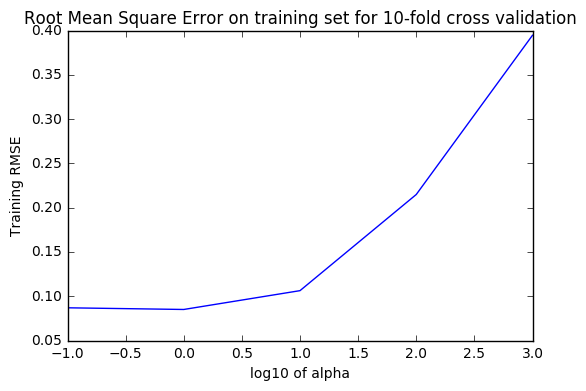

In [182]:
fig = plt.figure()
plt.plot(np.log10(alphas), trainMeanRMSEs)
plt.title('Root Mean Square Error on training set for %d-fold cross validation' % k,
         fontsize=12)
plt.ylabel('Training RMSE')
plt.xlabel('log10 of alpha')
plt.show()

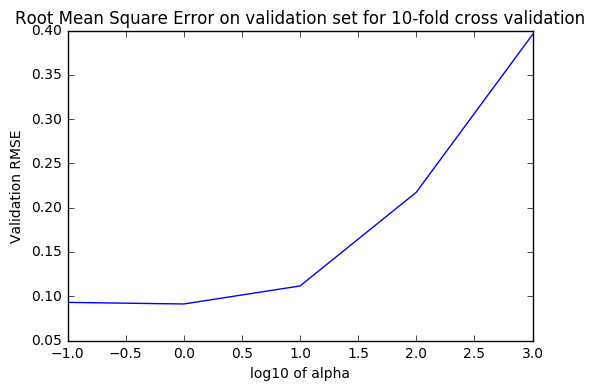

In [183]:
fig = plt.figure()
plt.plot(np.log10(alphas), validationMeanRMSEs)
plt.title('Root Mean Square Error on validation set for %d-fold cross validation' % k,
         fontsize=12)
plt.ylabel('Validation RMSE')
plt.xlabel('log10 of alpha')
plt.show()

From the two graphs above we understand that we need to explore for smaller values of alpha

In [184]:
alphas = np.logspace(-3, 1, num=5)
alphas

array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01])

In [185]:
trainErrors = np.zeros(resultsShape)
validationErrors = np.zeros(resultsShape)
run_start_time = time.time()
fitAndValidateForMultipleAlphas(alphas) #long running script because we need to run the neural network 50 times
run_time = time.time() - run_start_time
run_time

1274.1242611408234

In [186]:
trainMeanRMSEs = np.mean(trainErrors, axis=0)
trainMeanRMSEs.shape

(5,)

In [187]:
validationMeanRMSEs = np.mean(validationErrors, axis=0)
validationMeanRMSEs.shape

(5,)

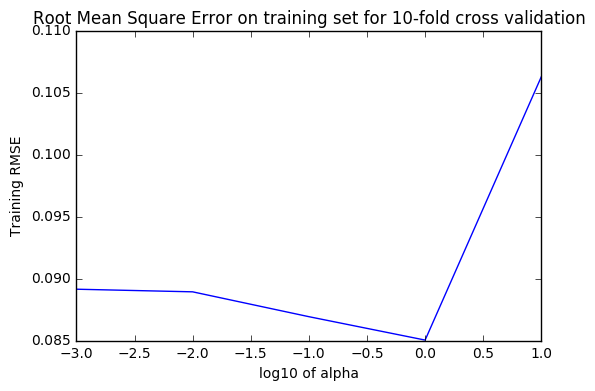

In [188]:
fig = plt.figure()
plt.plot(np.log10(alphas), trainMeanRMSEs)
plt.title('Root Mean Square Error on training set for %d-fold cross validation' % k,
         fontsize=12)
plt.ylabel('Training RMSE')
plt.xlabel('log10 of alpha')
plt.show()

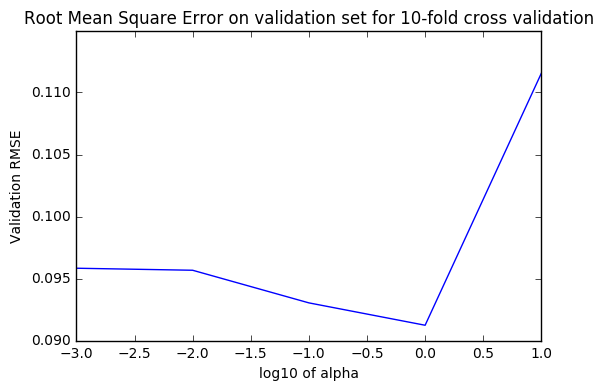

In [189]:
fig = plt.figure()
plt.plot(np.log10(alphas), validationMeanRMSEs)
plt.title('Root Mean Square Error on validation set for %d-fold cross validation' % k,
         fontsize=12)
plt.ylabel('Validation RMSE')
plt.xlabel('log10 of alpha')
plt.show()

In [190]:
print "the best RMSE is achieved by alpha:"
bestAlpha = alphas[np.argmin(validationMeanRMSEs)]
bestAlpha

the best RMSE is achieved by alpha:


1.0

We are going to retrain the neural network using the entire dataset based on this alpha and then we are going to test on the testing set which is unseen data we have not worked with before in this assignment

In [191]:
fittedParams, trainRMSE, testRMSE = fitNeuralNetwork(trainInputs=Xall, trainTargets=yAll,
                                                     validInputs=Xtesting, validTargets=yTest, alpha=bestAlpha)

In [192]:
print "training RMSE for the neural network with optimal alpha is"
trainRMSE

training RMSE for the neural network with optimal alpha is


(0.08385678969088153,)

In [193]:
print "testing RMSE for the neural network with optimal alpha is"
testRMSE

testing RMSE for the neural network with optimal alpha is


0.2949036328213312

Let's compare the above values with the simple case where we had the alpha = 10

In [194]:
fittedParams, trainRMSE_alpha10, testRMSE_alpha10 = fitNeuralNetwork(trainInputs=Xall, trainTargets=yAll,
                                                     validInputs=Xtesting, validTargets=yTest, alpha=10)

In [199]:
print "training RMSE for the neural network with alpha 10 is"
trainRMSE_alpha10

training RMSE for the neural network with alpha 10 is


(0.10395701898016467,)

In [198]:
print "testing RMSE for the neural network with alpha 10 is"
testRMSE_alpha10

testing RMSE for the neural network with alpha 10 is


0.28177834079572883

The training error is reduced when choosing the optimal alpha for training: ~0.083 < ~0.104

But the testing error in the unseen data is lower when training data used the alpha=10 as we used in previous exercises

We are going to repeat the previous two fit-and-RMSE of the neural network but this time we are going to use the training set as the training set and the validation set as testing set in order to be able and compare with the results of previous exercises

In [200]:
fittedParams, trainRMSE, testRMSE = fitNeuralNetwork(trainInputs=Xtr, trainTargets=yTrain,
                                                     validInputs=Xvalid, validTargets=yVal, alpha=bestAlpha)

print "training RMSE for the neural network with optimal alpha is"
print trainRMSE
print
print "testing RMSE for the neural network with optimal alpha is"
print testRMSE

training RMSE for the neural network with optimal alpha is
(0.07919593358323644,)

testing RMSE for the neural network with optimal alpha is
0.240008558659


In [201]:
fittedParams, trainRMSE_alpha10, testRMSE_alpha10 = fitNeuralNetwork(trainInputs=Xtr, trainTargets=yTrain,
                                                     validInputs=Xvalid, validTargets=yVal, alpha=10)

print "training RMSE for the neural network with alpha 10 is"
print trainRMSE_alpha10
print 
print "testing RMSE for the neural network with alpha 10 is"
print testRMSE_alpha10

training RMSE for the neural network with alpha 10 is
(0.10026697346626232,)

testing RMSE for the neural network with alpha 10 is
0.261324563952


*Note the last cell are just the results of the last run of the previous exercise, exercise 5, put again here for easier comparison*

So as a conclusion we see that the training error is reduced and so is the validation error which means that cross-validation was a reliable procedure to output the best alpha parameter to use for regularization